# Theoretical background

Thesis entitled *The Metropolis-Hastings Algorithm: Inverse Problems, Model Calibration, and the TOMGRO Model*


Notebook done by **Carlos Nosa**. 




We are going to use the following packages:

In [11]:
using Distributions
using Plots
using Random
using Statistics
using LinearAlgebra

## Differential equations

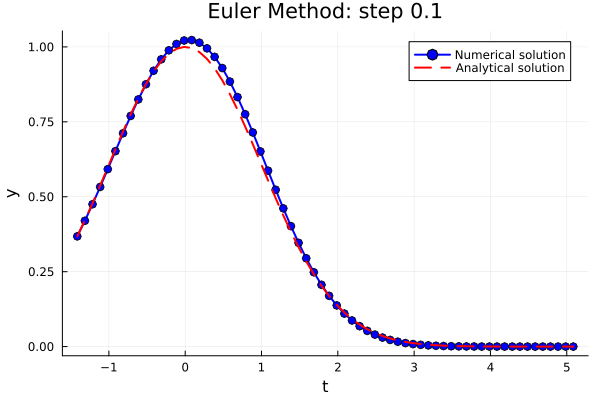

In [12]:
f0(t,y) = -t * y
function euler_explicito(f, y0, t0, t_end, h)
    t = t0
    y = y0
    resultados = [(t, y)]
    while t < t_end
        y_next = y + h * f(t, y)
        y = y_next
        t += h
        push!(resultados, (t, y))
    end
    return resultados
end

resultados_euler_explicito = euler_explicito(f0, exp(-1.0), -sqrt(2.0), 5.0, 0.1)

begin
	plot([r[1] for r in resultados_euler_explicito], [r[2] for r in resultados_euler_explicito], label="Numerical solution", lw=2, marker=:o, color=:blue,title="Euler Method: step 0.1",xlabel="t",ylabel="y")
	plot!([r[1] for r in resultados_euler_explicito], [exp(-0.5 *r[1]^2) for r in resultados_euler_explicito], label="Analytical solution", lw=2, linestyle=:dash, color=:red)
end

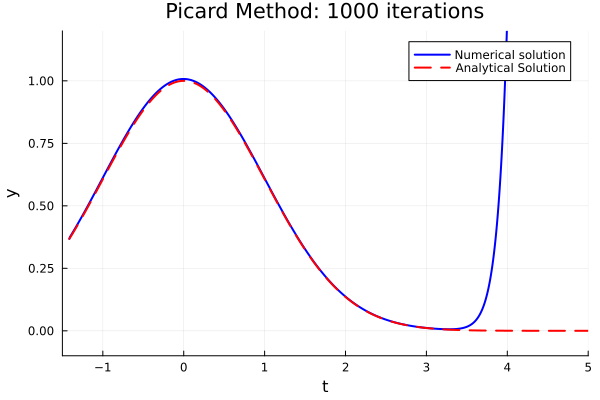

In [13]:
function picard(f, y0, t0, t_end, N; tol=1e-7, max_iter=100)
    t = [t0 + i*(t_end-t0)/(N-1) for i in 0:N-1]
    y = [y0 for i in 1:N]
    resultados = [copy(y)]  
    for k in 1:max_iter
        y_new = copy(y)
        for i in 2:N  
            y_new[i] = y0 + sum([f(t[j], y[j])*(t[i] - t[i-1]) for j in 1:i])
        end
		if norm(y-y_new)<tol
			return t, resultados
		end
        y = y_new
        push!(resultados, copy(y)) 
    end
    return t, resultados
end
resultados_picard = picard(f0, exp(-1.0), -sqrt(2.0), 5.0, 1000)

begin
	plot(resultados_picard[1],resultados_picard[2][15],label="Numerical solution",title="Picard Method: 1000 iterations",xlabel="t",ylabel ="y",legend=:topright,xlim=[-1.5,5],ylim=[-0.1,1.2],lw=2,color=:blue)
	plot!(resultados_picard[1],[exp(-0.5 * resultados_picard[1][l]^2) for l in 1:length(resultados_picard[1])],label="Analytical Solution",linewidth=2,lw=2, linestyle=:dash, color=:red)
end

## Markov Chains

In [14]:
function stationary_distribution(P)
    vals, vecs = eigen(P')
    idx = argmax(-abs.(vals .- 1)) 
    π = vecs[:, idx]
    π  = π ./ sum(π) 
    return π 
end

function simulate_markov_chain(P, initial_state, steps)
    state = initial_state
    history = [state]
    for _ in 1:steps
        state = state * P
        push!(history, state)
    end
    return history
end

P = [
    0.95 0.05 0.0 0.0;
    0.05 0.9 0.05 0.0;
    0.0 0.01 0.98 0.01;
    0.0 0.0 0.05 0.95;
]
initial_state = [0.25 0.25 0.25 0.25]  
steps = 100

π = stationary_distribution(P)
println("Stationary distribution: $π")

Stationary distribution: [0.1249999999999956, 0.12499999999999961, 0.6250000000000032, 0.1250000000000015]


## Statistical perspective

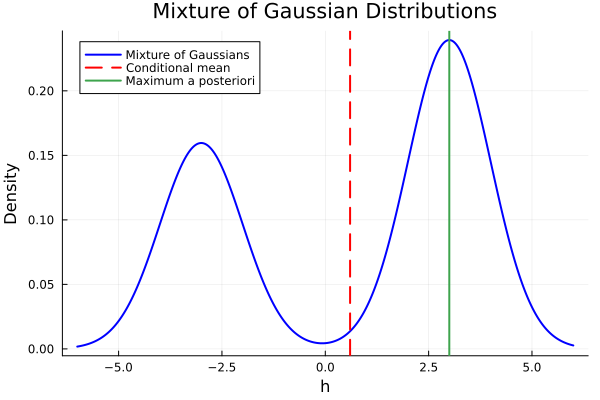

In [15]:
weights = [0.6, 0.4] 
means = [3.0, -3.0]    
stds = [1.0, 1.0]       
gaussians = [Normal(μ, σ) for (μ, σ) in zip(means, stds)]


function mixture_density(x)
    sum(w * pdf(g, x) for (w, g) in zip(weights, gaussians))
end


weighted_mean = sum(w * μ for (w, μ) in zip(weights, means))


x = range(-6, 6, length=500)


y = [mixture_density(xi) for xi in x]


plot(x, y, label="Mixture of Gaussians", lw=2, color=:blue)
xlabel!("h")
ylabel!("Density")
title!("Mixture of Gaussian Distributions")


vline!([weighted_mean], label="Conditional mean", color=:red, lw=2, linestyle=:dash)

vline!([3.0],label="Maximum a posteriori",lw=2)

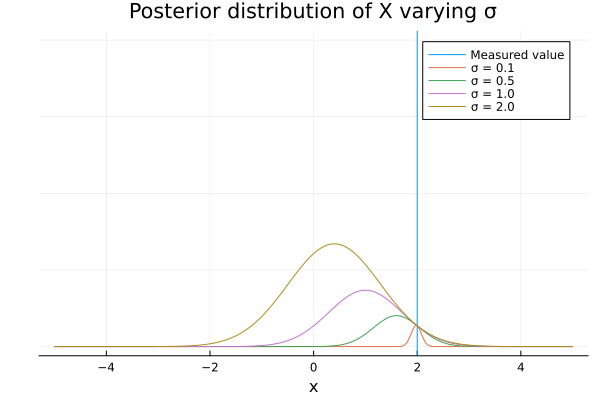

In [16]:

function gaussian_expression(x, σ, y)
    exp(-0.5 * x^2 - 0.5 * (1 / σ^2) * (y - x)^2)
end

y = 2.0                      
σ_values = [0.1, 0.5, 1.0, 2.0]   
x = range(-5, 5, length=500) 


p1 = plot(title="Posterior distribution of X varying σ", xlabel="x",yaxis=false, lw=2)
p1 = vline!([y],label="Measured value")
for σ in σ_values
    y_values = [gaussian_expression(xi, σ, y) for xi in x]
    p1 = plot!(x, y_values, label="σ = $σ")
end
p1

## Monte Carlo integration

In [17]:
function monte_carlo_beta_integral(alpha, beta, n_samples=10^6)
    dist = Beta(alpha, beta)  
    samples = rand(dist, n_samples)  
    integral_estimate = mean((samples .- 1/2) .^ 2) 
    return integral_estimate
end


alpha = 2
beta = 5
n_samples = 10^6

integral_value = monte_carlo_beta_integral(alpha, beta, n_samples)
println("Estimación de la integral: ", integral_value)

Estimación de la integral: 0.0714034301739974


In [18]:
function monte_carlo_uniform_integral(n_samples=10^6)
    dist = Uniform(0, 1)  
    samples = rand(dist, n_samples)  
    integral_estimate = mean(12*(samples .- 1/2) .^ 2)  
    return integral_estimate
end

n_samples = 10^6

integral_value = monte_carlo_uniform_integral(n_samples)
println("Estimación de la integral: ", integral_value)

Estimación de la integral: 1.0000090792591603


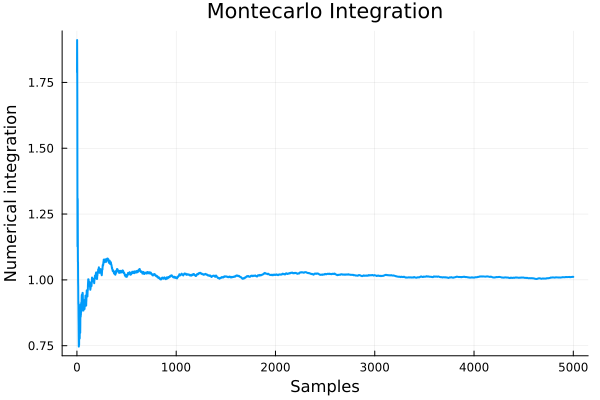

In [19]:
samples = rand(Uniform(0, 1), 5000) 
integral_estimate = [mean(12*(samples[1:t] .- 1/2) .^ 2) for t in 1:5000]
plot(integral_estimate, title="Montecarlo Integration", label="",xlabel="Samples", ylabel="Numerical integration", lw=2)

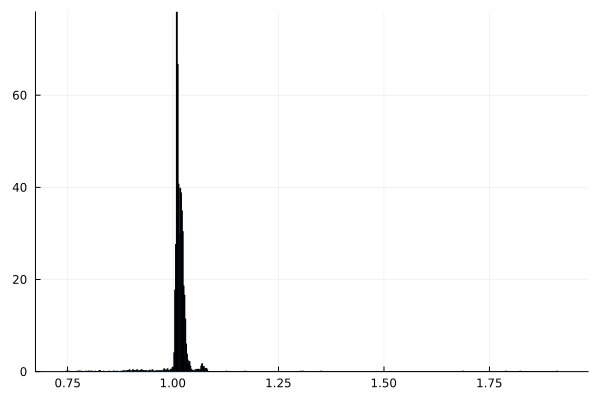

In [22]:
histogram(integral_estimate, normalize=true,label="")

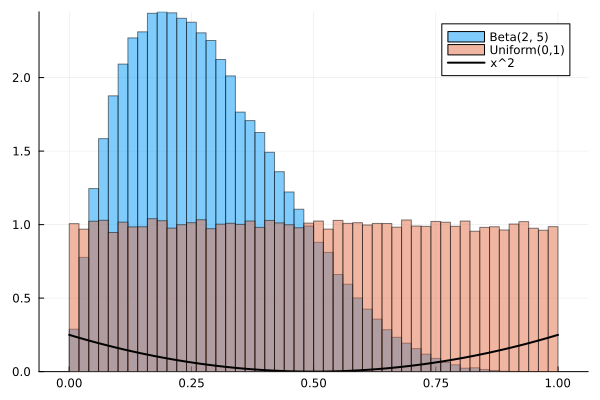

In [21]:
function plot_distributions_and_integrand(alpha, beta, n_samples=10^6)
    beta_dist = Beta(alpha, beta)
    uniform_dist = Uniform(0, 1)

    beta_samples = rand(beta_dist, n_samples)
    uniform_samples = rand(uniform_dist, n_samples)

    hist_beta = histogram(beta_samples, bins=50, normalize=:pdf, alpha=0.5, label="Beta($alpha, $beta)")
    hist_uniform = histogram!(uniform_samples, bins=50, normalize=:pdf, alpha=0.5, label="Uniform(0,1)")

    x = range(0, 1, length=100)
    plot!(x, (x .- 1/2).^2, lw=2, label="x^2", color=:black)

    return hist_beta
end

alpha = 2
beta = 5
n_samples = 10^5

plot_distributions_and_integrand(alpha, beta, n_samples)